# Jan Izydorczyk
# Sprawozdanie 9

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import random
import scipy
import sys
%matplotlib notebook

print("Wersja Pythona:")
print (sys.version)
print(f"Wersja numpy: {np.__version__}")
print("Konfiguracja liczb zmiennoprzecinkowych")
print(sys.float_info)

f64 = np.float64
f32 = np.float32

Wersja Pythona:
3.9.4 (tags/v3.9.4:1f2e308, Apr  6 2021, 13:40:21) [MSC v.1928 64 bit (AMD64)]
Wersja numpy: 1.20.2
Konfiguracja liczb zmiennoprzecinkowych
sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


In [2]:
from scipy.linalg import lu_factor, lu_solve
from itertools import chain, product
from timeit import timeit
import pandas as pd
from mpmath import nstr, mpf

In [3]:
import networkx as nx
import graphviz as gv

# Zadanie 1

#### Funkcja tworząca losowy spójny graf skierowany

In [4]:
from itertools import combinations, groupby
def gnp_random_connected_graph(n, p=0.1):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = reversed(random_edge)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                if random.random() < 0.5:
                    e = reversed(e)
                G.add_edge(*e)
    return G

#### Funkcja tworząca losowy silnie spójny graf skierowany

In [5]:
def gnp_random_strongly_connected_graph(n, p=0.2):
    s = set()
    while len(s) < n:      
        G = gnp_random_connected_graph(n, p)
        s = max(nx.strongly_connected_components(G), key=len)
    return G

In [6]:
G = gnp_random_strongly_connected_graph(10, p=0.1)

### Przykładowy graf silnie spójny, 10 wierzchołków

<IPython.core.display.Javascript object>


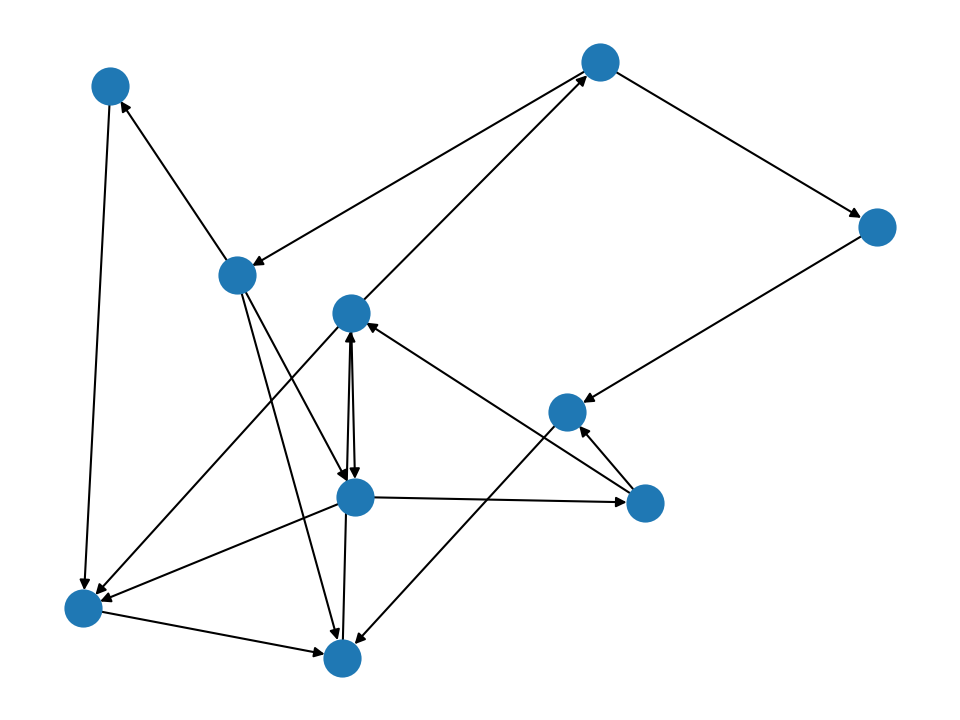

In [7]:
nx.draw(G)

#### Funkcja tworząca macierz adiacencji dla danego grafu

Wagi krawędzi są liczone wegdług następujących wzorów:

$$r = cAr$$

$$A_{u, v}=
    \begin{cases}
      \frac{1}{N_u}, & \text{jeżeli krawędź}\ (u, v) \text{ istnieje} \\
      0, & \text{wpp}
    \end{cases} $$

In [8]:
def trans_matrix(G, d=1):
    n = len(G)
    M = np.zeros(shape=(n, n))
    for node in G.nodes:
        nbors = G[node]
        for nbor in nbors:
            M[node, nbor] = 1 / len(nbors)
            
    return d * M

#### Metoda potęgowa

In [9]:
def eig_(method):
    def wrapper(M, *args, x_0=None, epsilon=None, max_steps=None, epsilon_buff=None, **kwargs):
        
        def pred(x_t1, x_t, steps):
            nonlocal max_steps, epsilon
            res = True
            if epsilon is not None:
                if steps > 2e4:
                    print('Overflow')
                    print('----')
                    print(np.linalg.norm(x_t1 - x_t))
                    print('----')
                    return False
                res =  np.linalg.norm(x_t1 - x_t) > epsilon and np.linalg.norm(x_t1 + x_t) > epsilon
            elif max_steps is not None:
                res = steps < max_steps
            else:
                res = False
            if epsilon is not None and epsilon_buff is not None:
                epsilon_buff.append(np.mean(np.abs(x_t - x_t1)))
            return res
        if x_0 is None:
            x_0 = np.random.rand(M.shape[0], 1)
        else:
            x_0 = np.copy(x_0)
            
        return method(M, *args, x_0=x_0, epsilon=epsilon, max_steps=max_steps, pred=pred, **kwargs)
    return wrapper

In [10]:
@eig_
def power_method(M, x_0=None, epsilon=None, max_steps=None, pred=None):
    x_t = x_0
    steps = 0
    x = x_t + 2
    
    while pred(x_t, x, steps):
        steps += 1
        x = x_t
        x_t = M @ x_t
        idx = np.argmax(np.abs(x_t))
        max_val = x_t[idx, 0]
        x_t /= max_val
    return max_val, x_t / np.linalg.norm(x_t)

#### Pierwsze testy

In [11]:
M = trans_matrix(G)

In [12]:
w, v = power_method(M.T, epsilon=1e-7)

In [13]:
np.sum(M, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [14]:
v /= np.sum(v)
print(f'Wartość własna macierzy: {w}')
print(f'Stan stacjonarny:\n{v.reshape(-1)}')

Wartość własna macierzy: 0.999999954169315
Stan stacjonarny:
[0.22260274 0.09589041 0.04109589 0.01369863 0.14383562 0.06506849
 0.0479452  0.04109589 0.24657534 0.08219178]


In [36]:
def pagerank(G):
    M = trans_matrix(G)
    _, v = power_method(M.T, epsilon=1e-7)
    v /= np.sum(v)
    return v.flatten()

### Testy

In [124]:
from mpmath import mpf, nstr

def test_graph(G):
    probs = pagerank(G) 
    return G, probs

def plot_graph(G, probs, ax=None, pos=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10, 10))
    if pos is None:
        pos = nx.kamada_kawai_layout(G)
    
    labels = {}
    for node, prob in zip(G.nodes, probs):
        labels[node] = prob
    nx.draw(G, ax=ax, labels=labels, with_labels = True, node_color='#FF9898', edge_color='gray', pos=pos)
    

def show_results(G, probs, show_graph=True, use_perc=True, print_probs=True):
    if use_perc:
        probs *= 100
    if show_graph:
        fig, (hist, graph) = plt.subplots(1, 2, figsize=(12, 6))
    else:
        fig = plt.figure(figsize=(6,6))
        hist = fig.add_subplot(1, 1, 1)
    
    probs_str = [nstr(mpf(x), 3) for x in probs.flatten()]
    
    if show_graph:
        graph.set_title('Graph with probabilities')
        plot_graph(G, probs_str, ax=graph)
    
    hist.set_title('Probabilities distribution')
    hist.set_ylabel('Distribution')
    hist.set_xlabel('Probability')
#     hist.set_xticks(probs)
    hist.hist(probs)
    if print_probs:
        probs_str = [nstr(mpf(x), 3) for x in sorted(probs.flatten())]
        print(f'Probabilities: {probs_str}')

    
    

### Grafy losowe

#### Graf rzadki, n = 10, p = 0.1

<IPython.core.display.Javascript object>


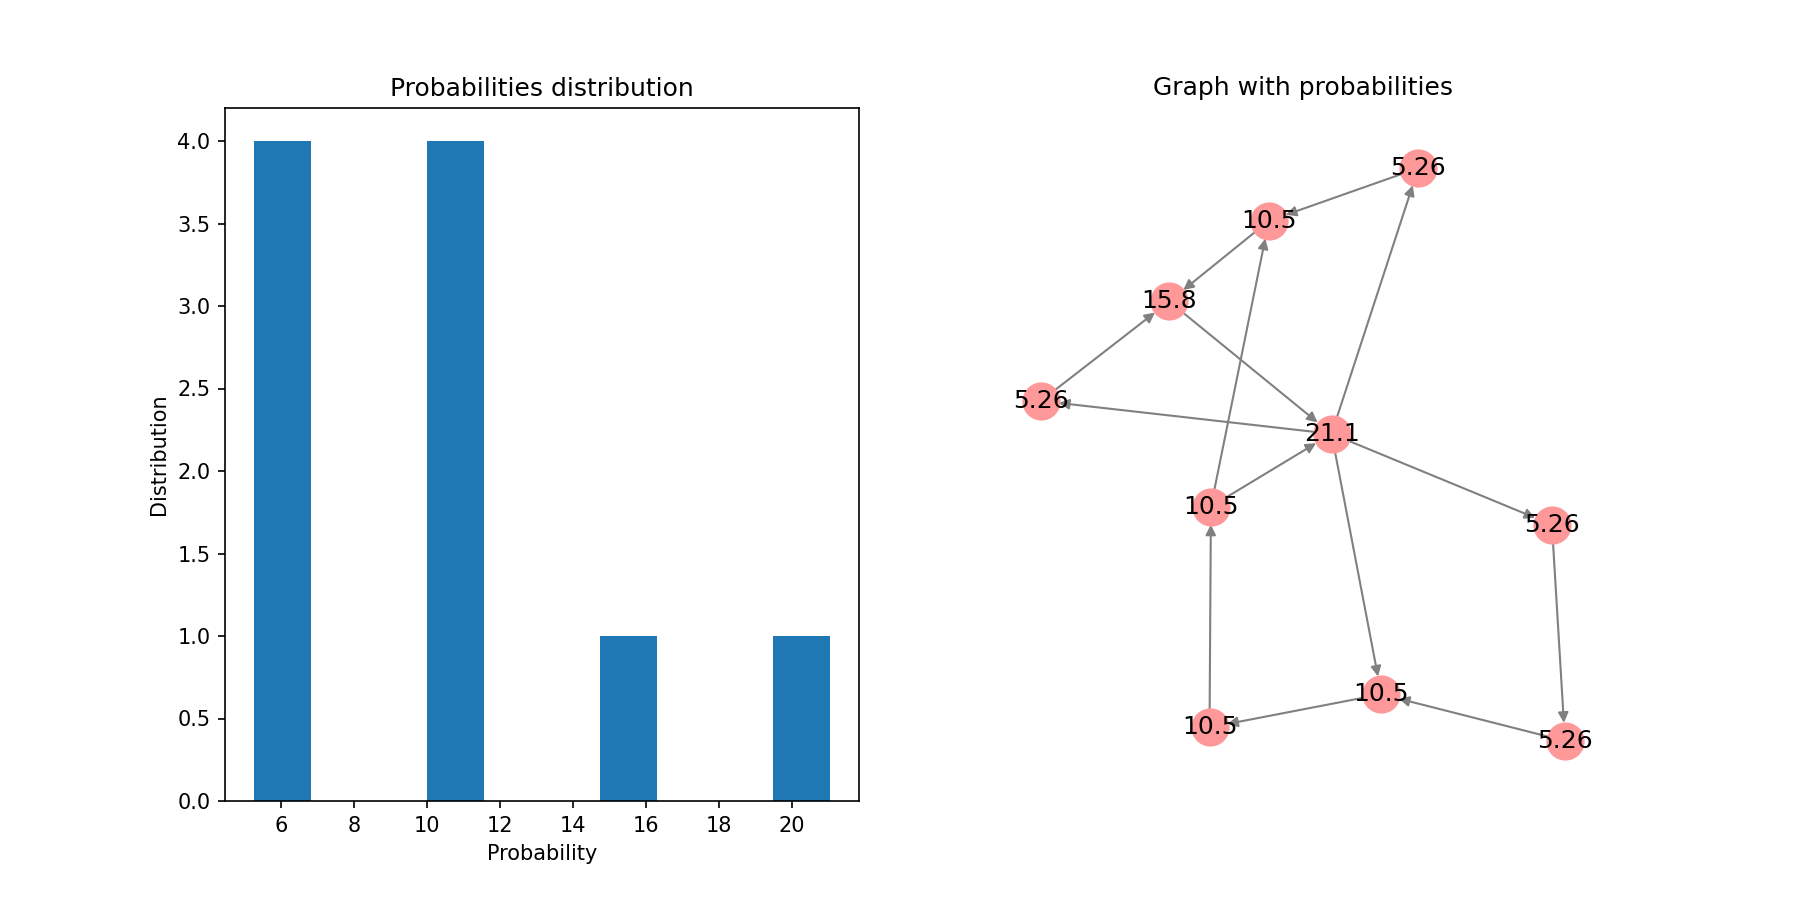

Probabilities: ['5.26', '5.26', '5.26', '5.26', '10.5', '10.5', '10.5', '10.5', '15.8', '21.1']


In [125]:
G = gnp_random_strongly_connected_graph(10, p=0.1)
probs = pagerank(G)
show_results(G, probs)

#### Graf rzadki, n = 30, p = 0.1

<IPython.core.display.Javascript object>


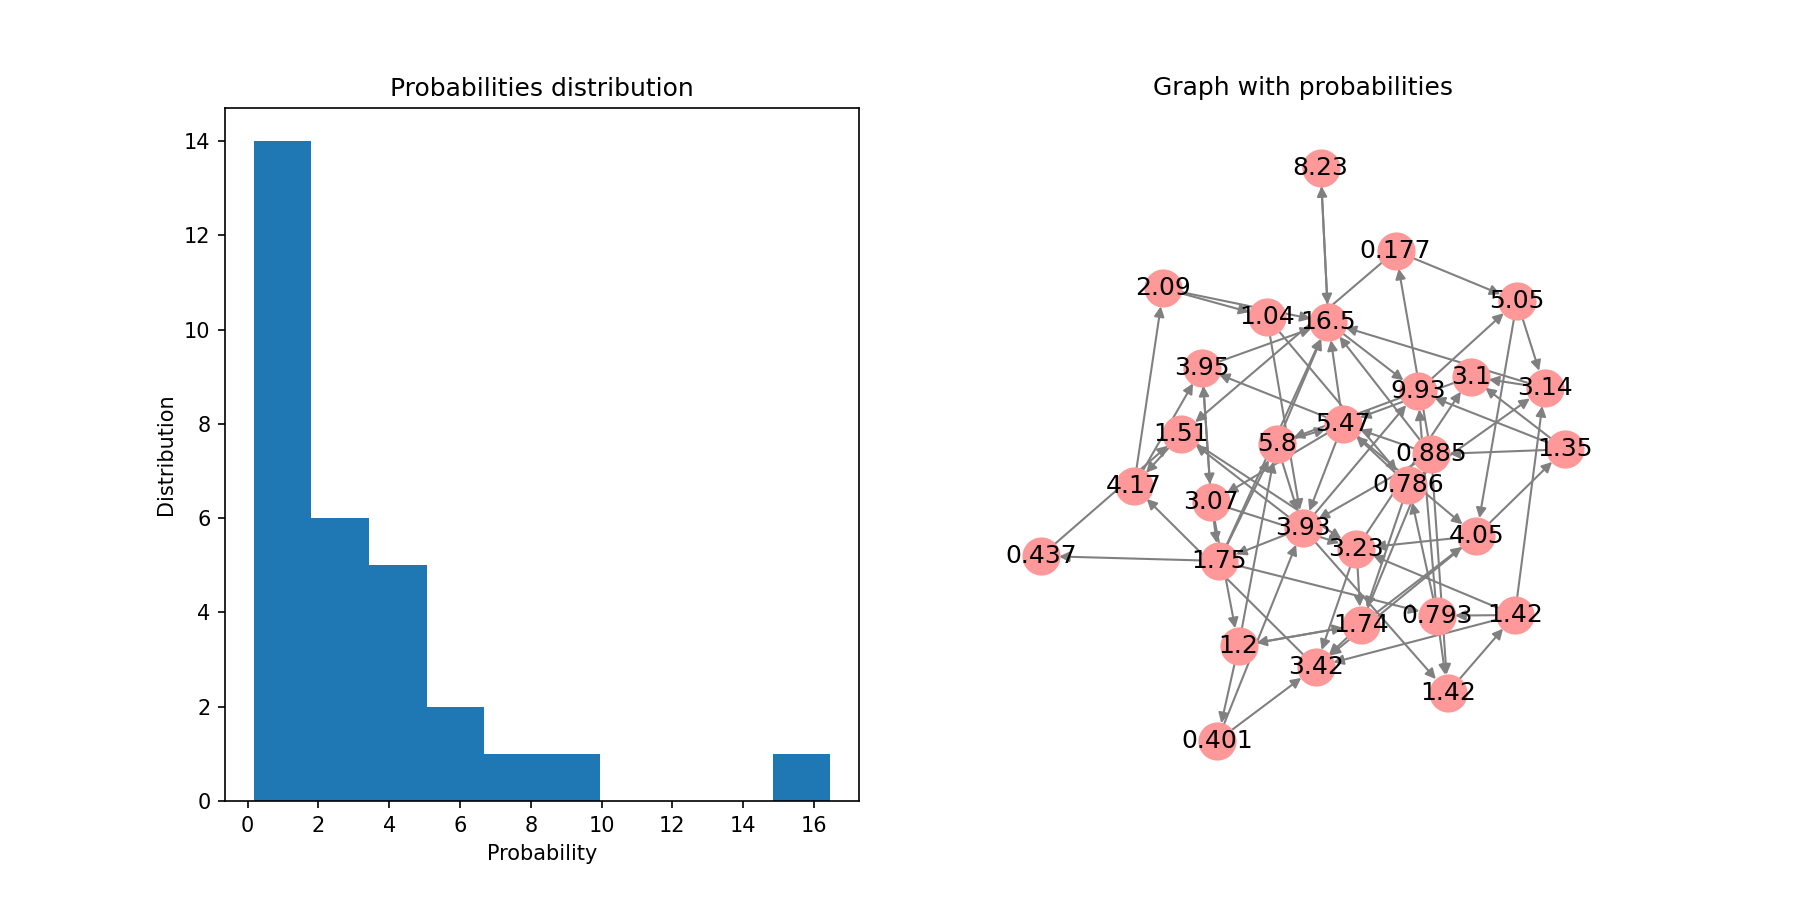

Probabilities: ['0.177', '0.401', '0.437', '0.786', '0.793', '0.885', '1.04', '1.2', '1.35', '1.42', '1.42', '1.51', '1.74', '1.75', '2.09', '3.07', '3.1', '3.14', '3.23', '3.42', '3.93', '3.95', '4.05', '4.17', '5.05', '5.47', '5.8', '8.23', '9.93', '16.5']


In [126]:
G = gnp_random_strongly_connected_graph(30, p=0.1)
probs = pagerank(G)
show_results(G, probs)

#### Graf względnie gęsty, n = 30, p = 0.5

<IPython.core.display.Javascript object>


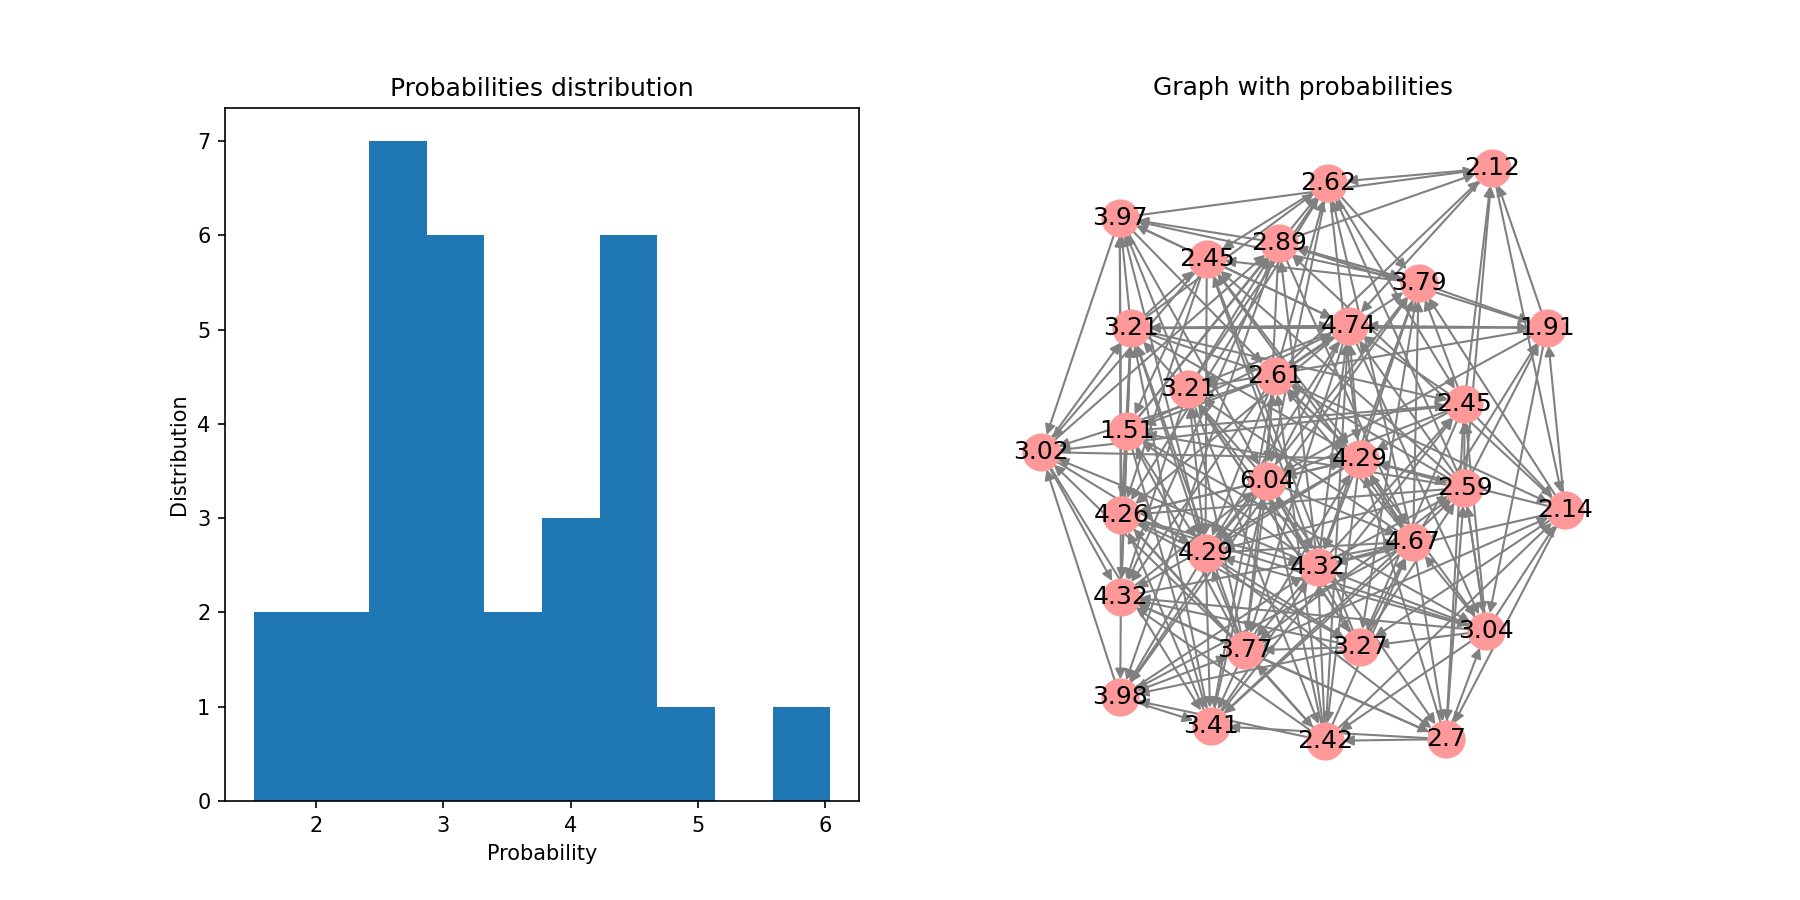

Probabilities: [1.51, 1.91, 2.12, 2.14, 2.42, 2.45, 2.45, 2.59, 2.61, 2.62, 2.7, 2.89, 3.02, 3.04, 3.21, 3.21, 3.27, 3.41, 3.77, 3.79, 3.97, 3.98, 4.26, 4.29, 4.29, 4.32, 4.32, 4.67, 4.74, 6.04]


In [57]:
G = gnp_random_strongly_connected_graph(30, p=0.5)
probs = pagerank(G)
show_results(G, probs)

#### Graf gęsty, n = 30, p = 0.9

<IPython.core.display.Javascript object>


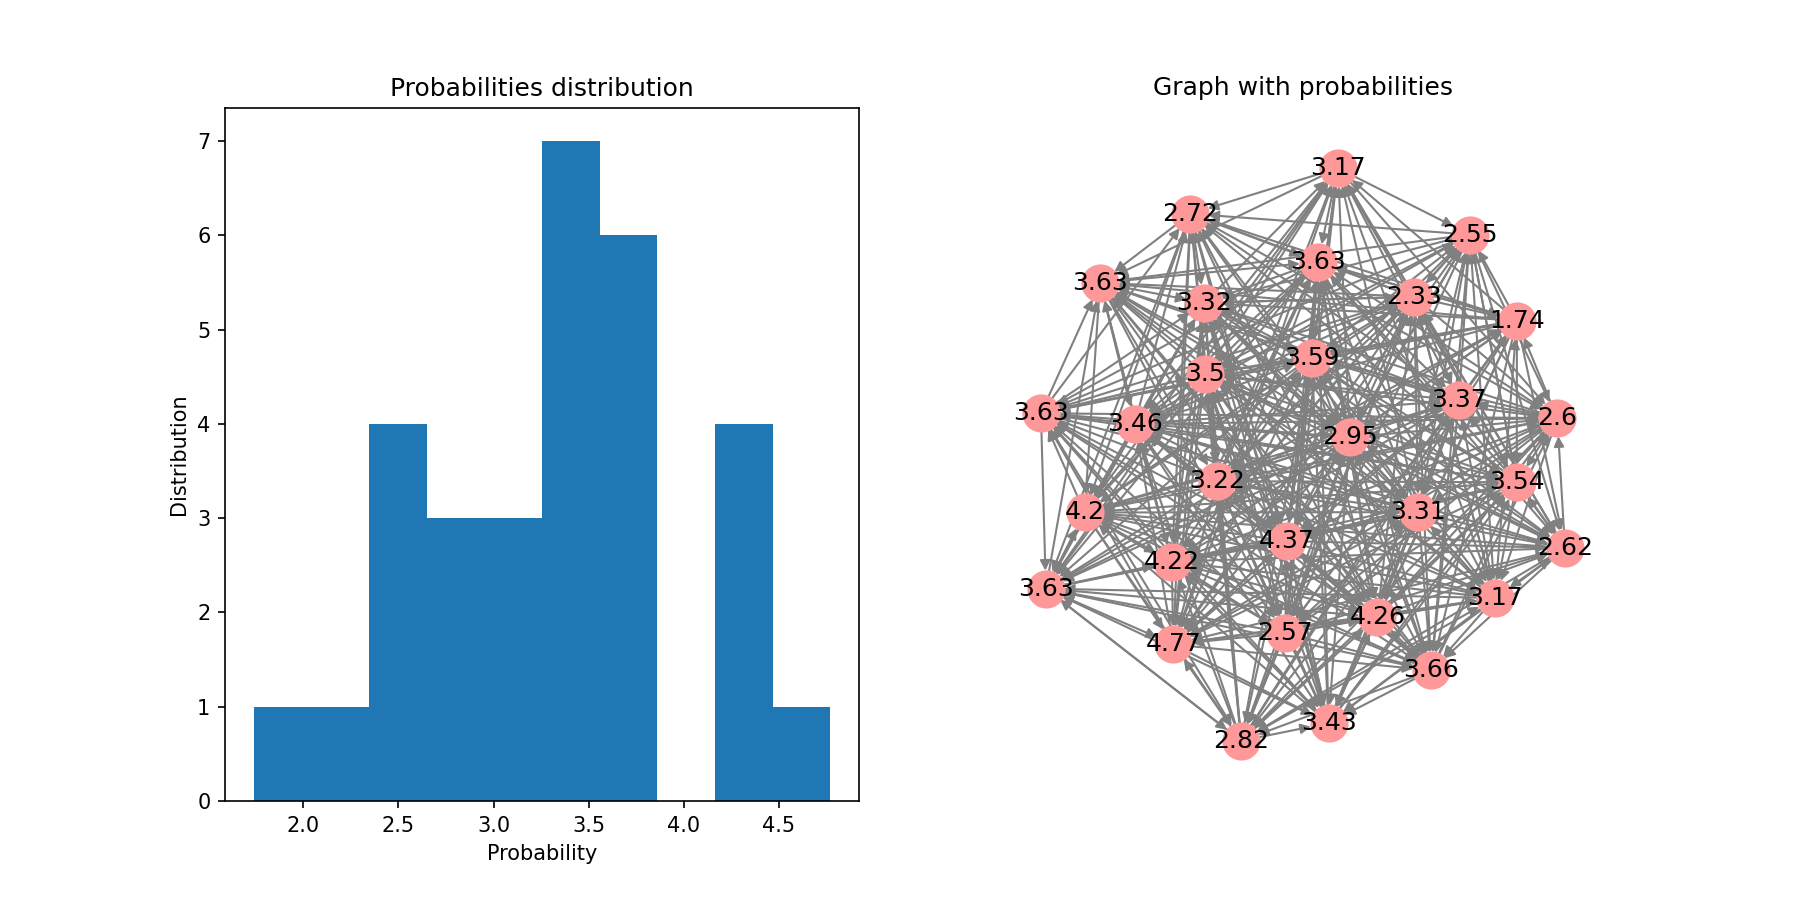

Probabilities: [1.74, 2.33, 2.55, 2.57, 2.6, 2.62, 2.72, 2.82, 2.95, 3.17, 3.17, 3.22, 3.31, 3.32, 3.37, 3.43, 3.46, 3.5, 3.54, 3.59, 3.63, 3.63, 3.63, 3.63, 3.66, 4.2, 4.22, 4.26, 4.37, 4.77]


In [58]:
G = gnp_random_strongly_connected_graph(30, p=0.9)
probs = pagerank(G)
show_results(G, probs)

### Grafy predefiniowane

#### Graf pełny, n = 30

<IPython.core.display.Javascript object>


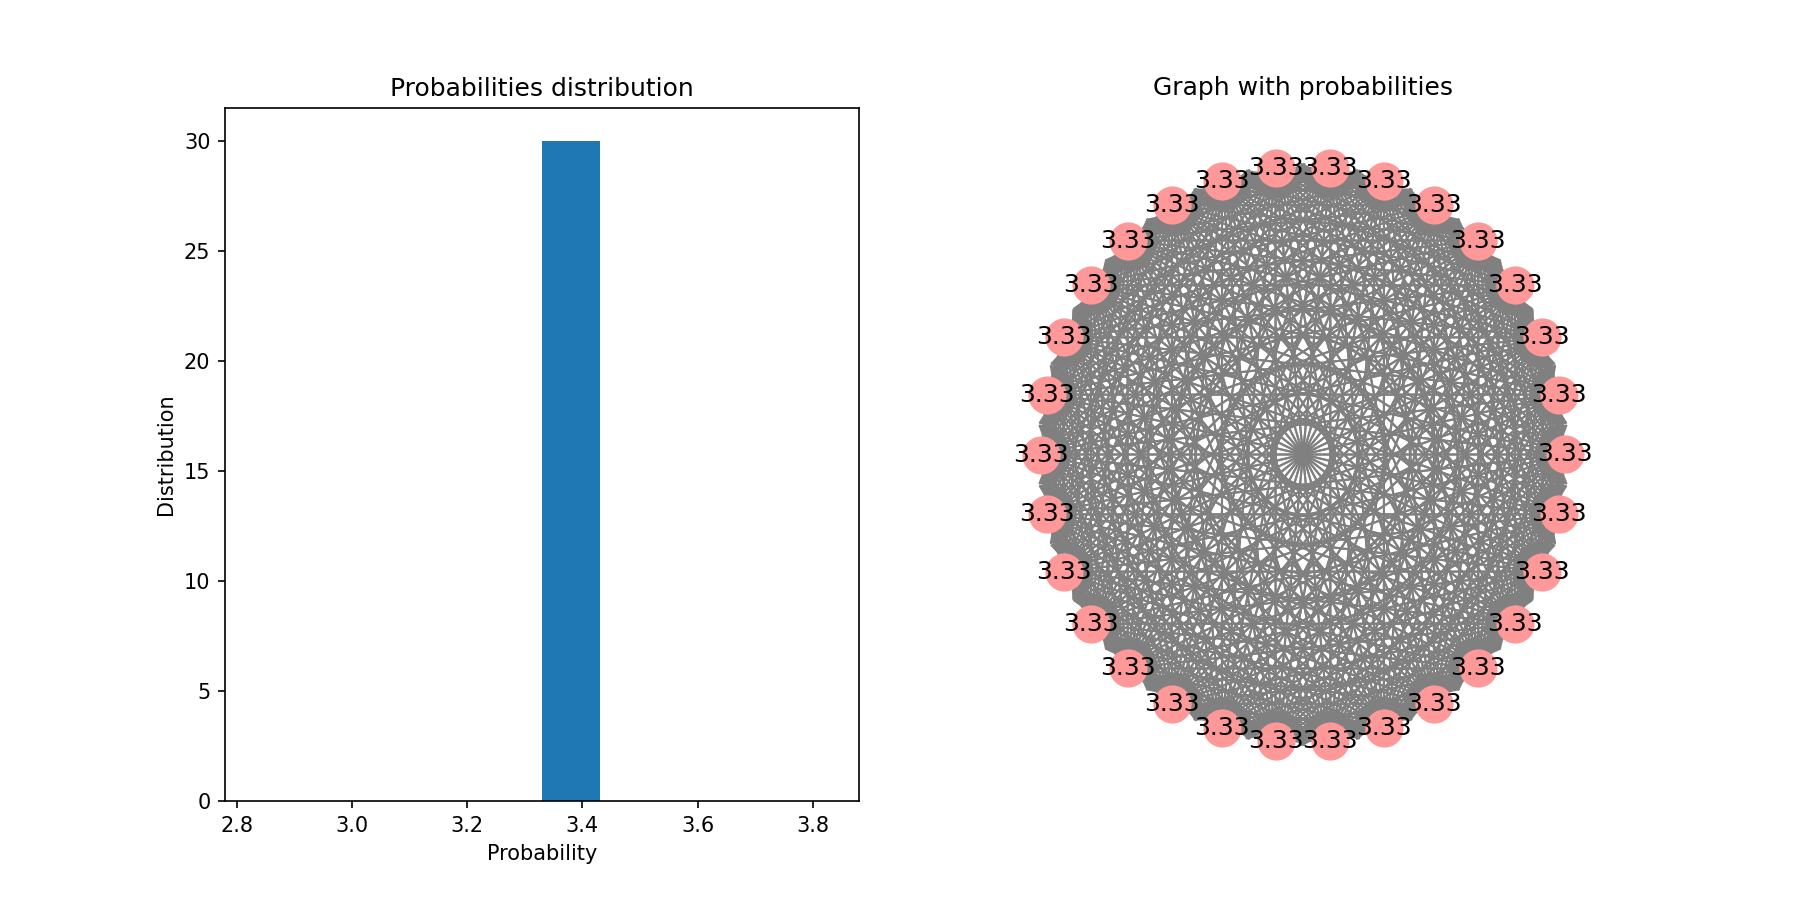

Probabilities: [3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33]


In [59]:
G = gnp_random_strongly_connected_graph(30, p=1)
probs = pagerank(G)
show_results(G, probs)

#### Cykl, n = 20

Overflow
----
1.9086671846697172
----


<IPython.core.display.Javascript object>


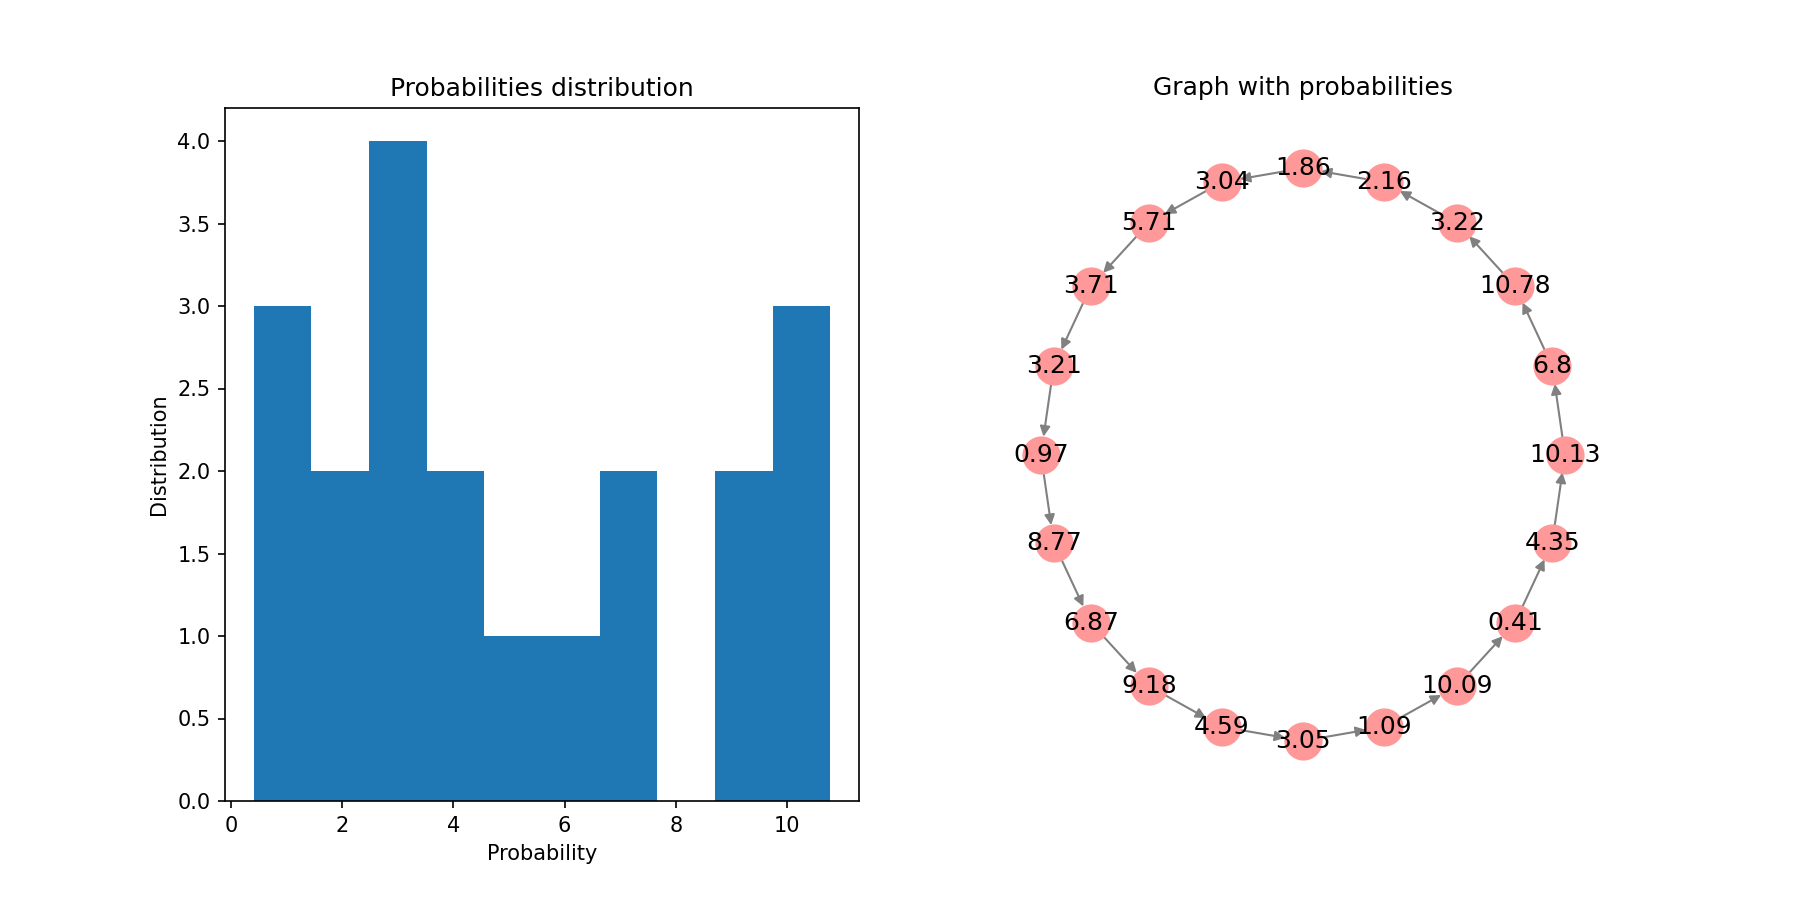

Probabilities: [0.41, 0.97, 1.09, 1.86, 2.16, 3.04, 3.05, 3.21, 3.22, 3.71, 4.35, 4.59, 5.71, 6.8, 6.87, 8.77, 9.18, 10.09, 10.13, 10.78]


In [60]:
G = nx.cycle_graph(20, create_using=nx.DiGraph)
probs = pagerank(G)
show_results(G, probs)

## Wnioski

Dla grafów losowych metoda wydaje się sprawdzać. Rozkład prawdopodobieństwa wydaję się mniej więcej jednorodny, jednak występują wierzchołki bardziej i mniej "popularne".

Dla grafów gęstych prawdopodobieństwo danych wierchołków oscyluje wokół wartości $\frac{1}{n}$, a dla grafów pełnych osiąga tą wartość.

Problematyczny okazał się być graf, będący cyklem. Dla macierzy adjencji metoda potęgowa wydaję się nie zbieżna, osiągając maksymalną liczbę iteracji, a wynikowy rozkład nie jest nawet bliski spodziewanego rozkładu jednostajnego.

Metoda ta nie wydaje się bazpośrednio odpowiednia dla dużych grafów. Tworzenie grafu adjencji dla dużych grafów i znajdowanie dla nich dominujących wartości własnych jest zbyt pamięcio- i czasochłonne 

# Zadanie 2

$$
r(u) = d \sum_{v \in B_u} \frac{r(v)}{N_v} + (1-d)e(u)
$$

$$
r = (dA + (1-d)e \otimes \textbf{1}
$$

In [75]:
def random_prob_vec(n):
    v = np.random.rand(n, 1)
    return v / np.linalg.norm(v, ord=1)

In [142]:
def pagerank_with_jumps(G, e, d=1):
    A = trans_matrix(G)
    B = d * A + (1 - d) * np.ones(shape=(e.shape[0], 1)) * e.reshape(1, -1)
    B = B.T
    n = B.shape[0]
    
    epsilon = 1e-5
    
    r_prev = random_prob_vec(n)
    e = e.reshape(-1, 1)
    
    sigma = 1 + epsilon
    
    while sigma > epsilon:
        r = B @ r_prev
        d = np.linalg.norm(r, ord=1) - np.linalg.norm(r_prev, ord=1)
        r += d * e
        sigma = np.linalg.norm(r - r_prev, ord=1)
        r_prev = r
    
    return r_prev 

In [81]:
e = np.array([1, 2, 3, 4])
np.ones(shape=(e.shape[0], 1)) * e.reshape(1, -1)
e.reshape(-1, 1)
e

array([1, 2, 3, 4])

#### Test dla grafu pełnego, z niejednostajnym wektorem e, d = 0.5

(7, 7) (7, 1)


<IPython.core.display.Javascript object>


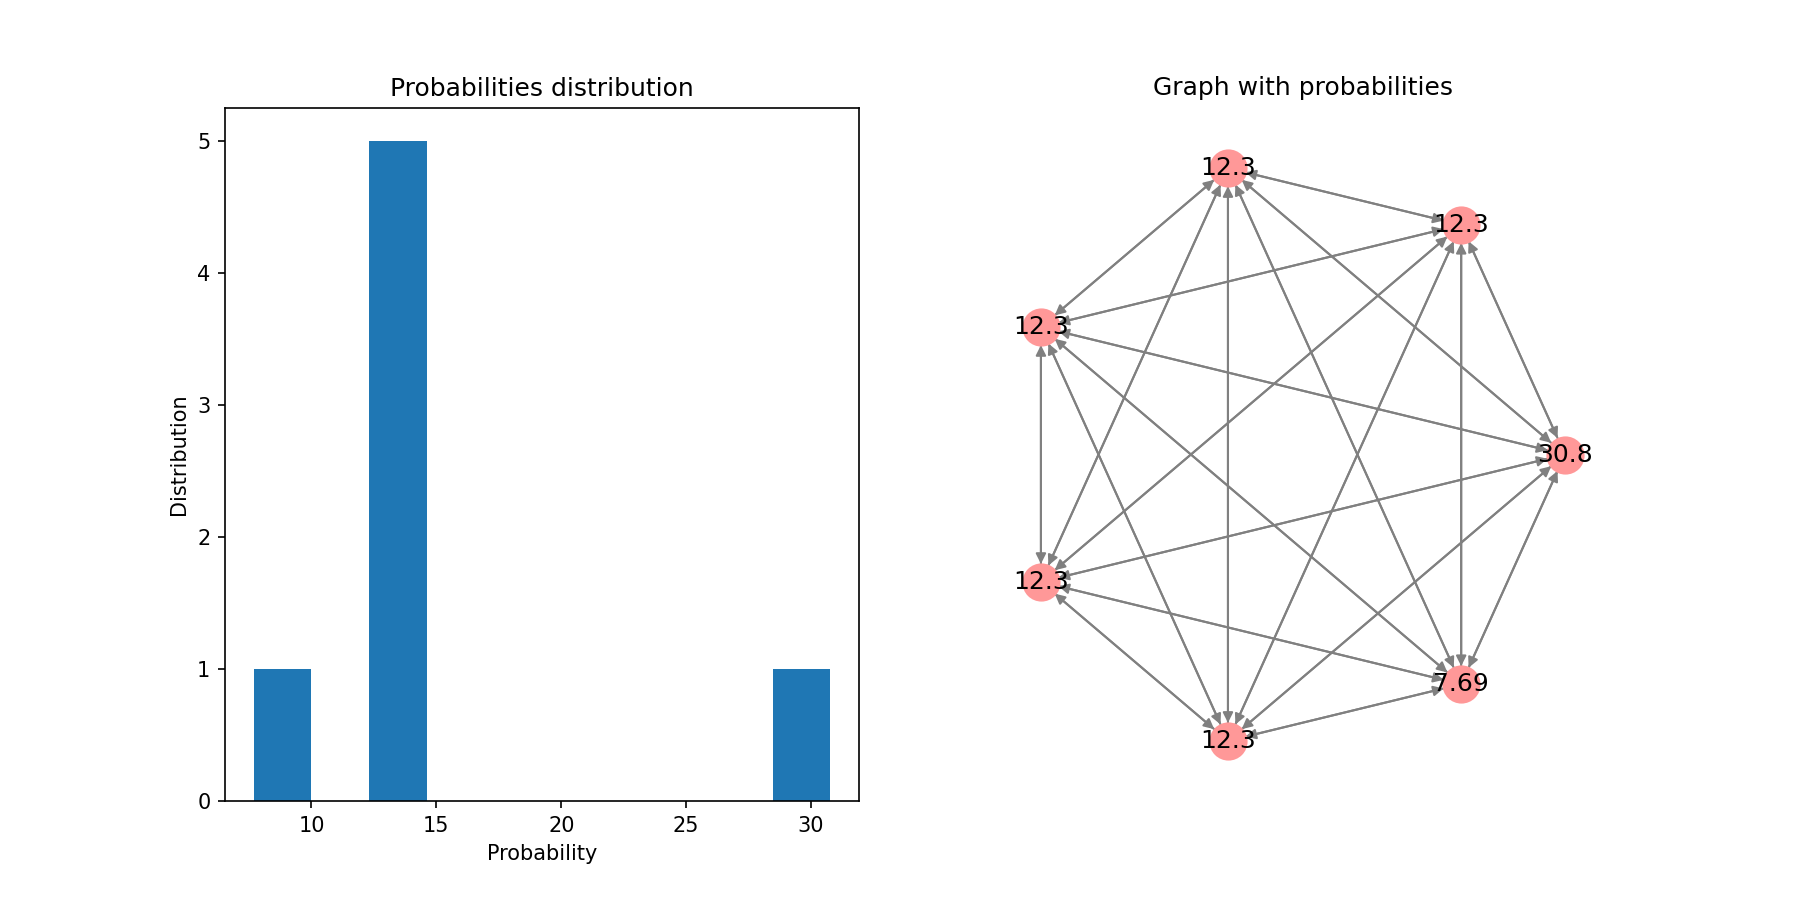

Probabilities: ['7.69', '12.3', '12.3', '12.3', '12.3', '12.3', '30.8']


In [127]:
n = 7
G = gnp_random_strongly_connected_graph(n, p=1)
e = np.array([0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0]).reshape(-1, 1)
probs = pagerank_with_jumps(G, e, d=0.5)
show_results(G, probs)

#### Test dla grafu rzadkiego, z jednostajnym wektorem e, d = 1

<IPython.core.display.Javascript object>


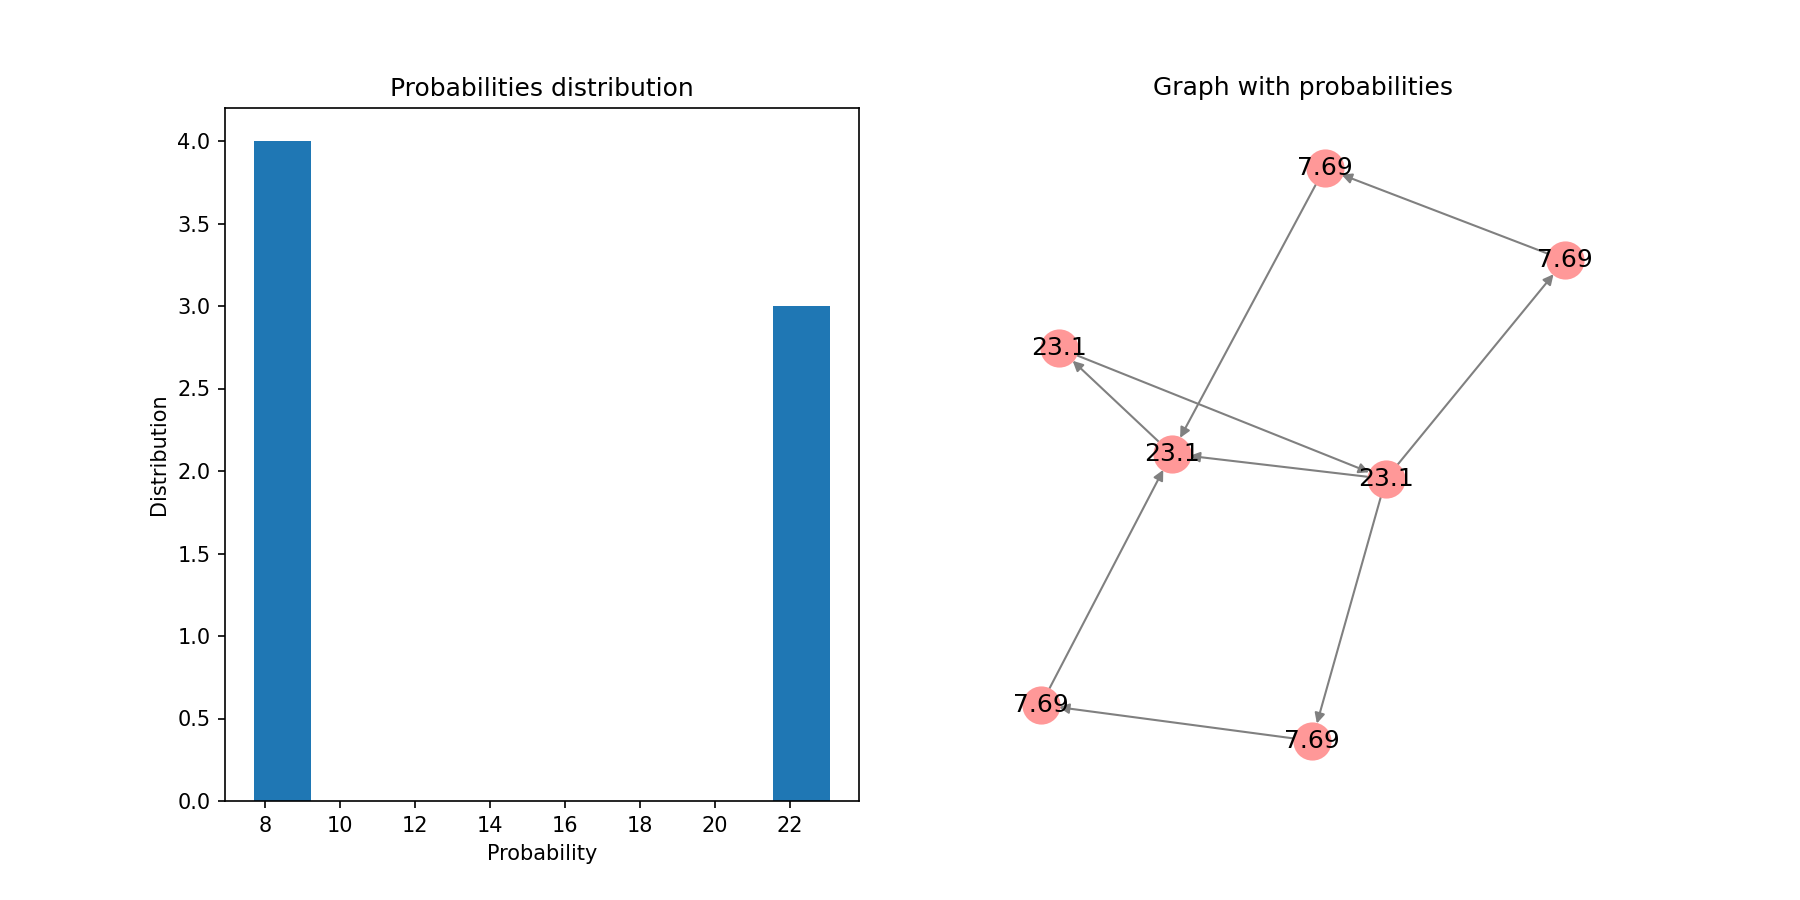

Probabilities: ['7.69', '7.69', '7.69', '7.69', '23.1', '23.1', '23.1']


In [167]:
n = 7
G = gnp_random_strongly_connected_graph(n, p=0.1)
e = np.ones((n, 1)) / n
probs = pagerank_with_jumps(G, e, d=1)
show_results(G, probs)

#### Test dla grafu rzadkiego, z jednostajnym wektorem e, d = 0.95

<IPython.core.display.Javascript object>


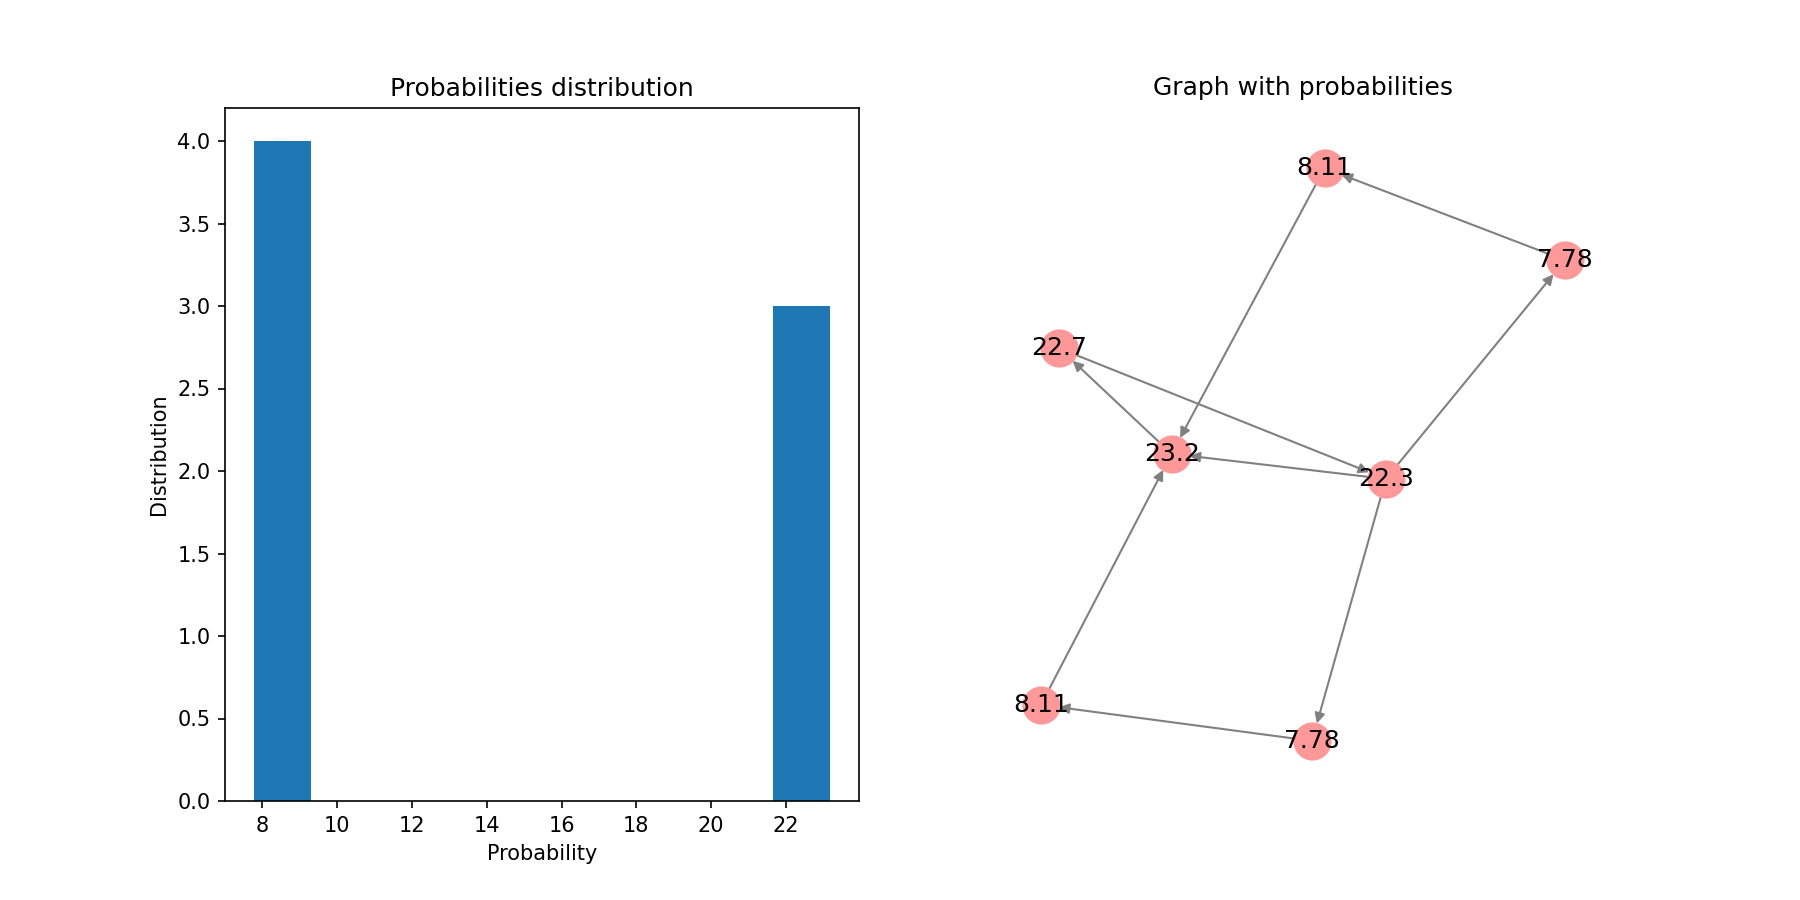

Probabilities: ['7.78', '7.78', '8.11', '8.11', '22.3', '22.7', '23.2']


In [172]:
probs = pagerank_with_jumps(G, e, d=0.95)
show_results(G, probs)

#### Test dla grafu rzadkiego, z jednostajnym wektorem e, d = 0.9

<IPython.core.display.Javascript object>


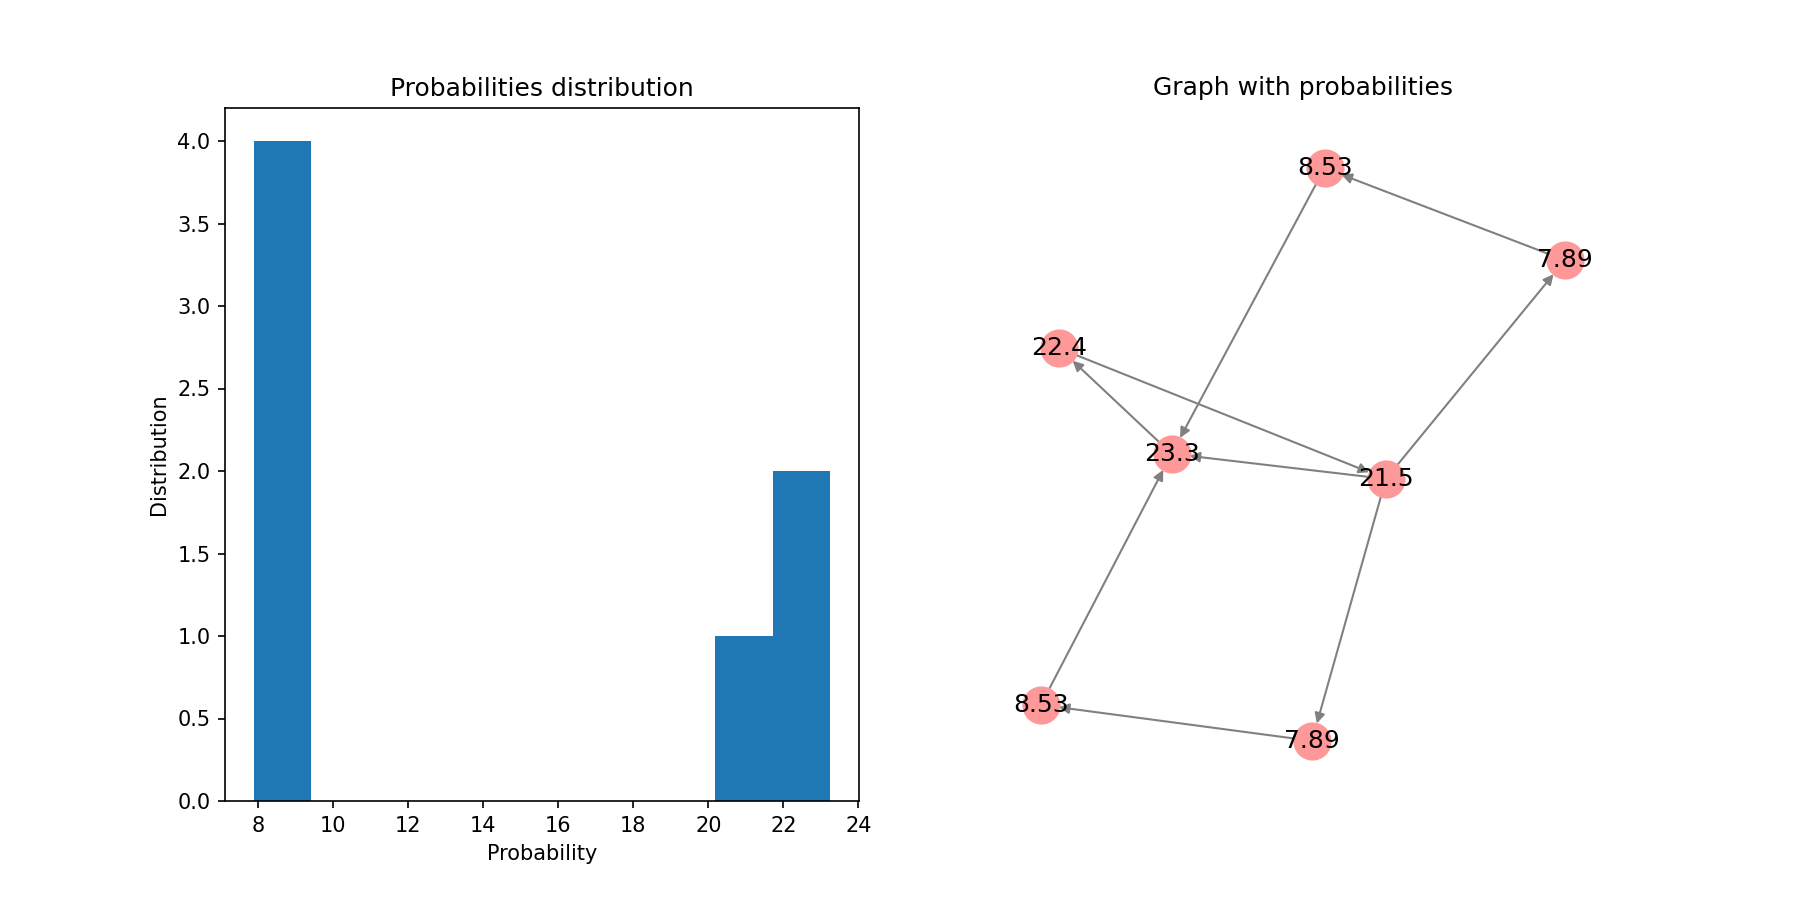

Probabilities: ['7.89', '7.89', '8.53', '8.53', '21.5', '22.4', '23.3']


In [171]:
probs = pagerank_with_jumps(G, e, d=0.9)
show_results(G, probs)

#### Test dla grafu rzadkiego, z jednostajnym wektorem e, d = 0.5

<IPython.core.display.Javascript object>


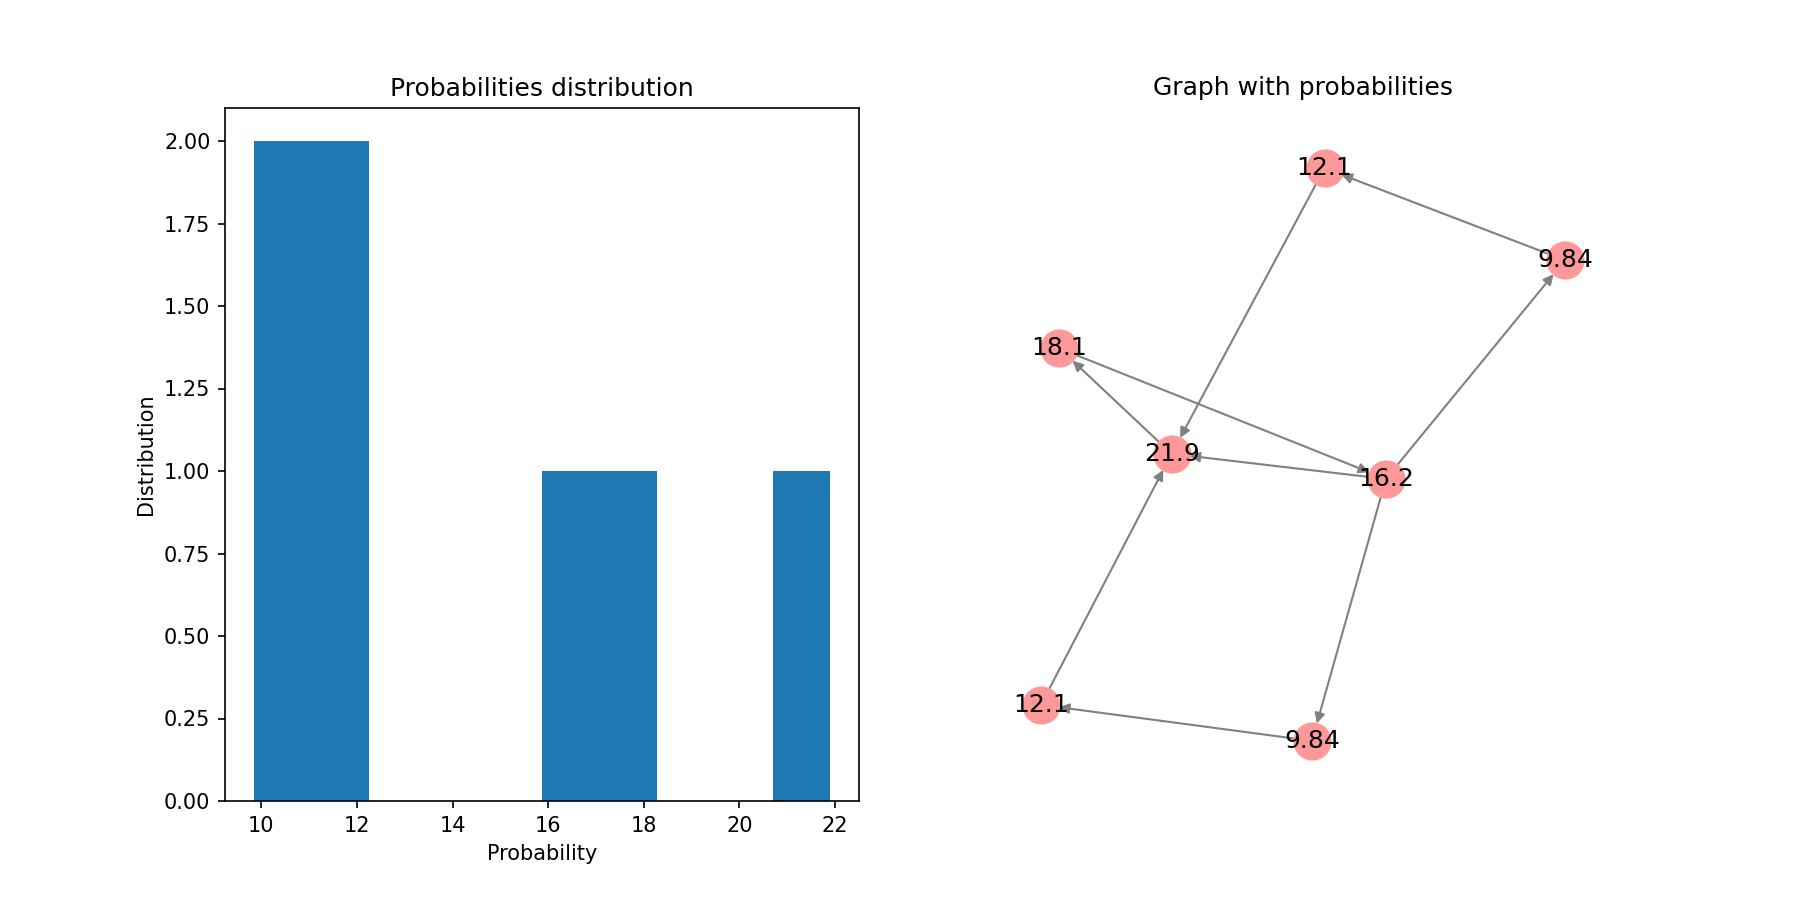

Probabilities: ['9.84', '9.84', '12.1', '12.1', '16.2', '18.1', '21.9']


In [174]:
probs = pagerank_with_jumps(G, e, d=0.5)
show_results(G, probs)

#### Test dla grafu pełnego, z niejednostajnym wektorem e, d = 0.9

(7, 7) (7, 1)


<IPython.core.display.Javascript object>


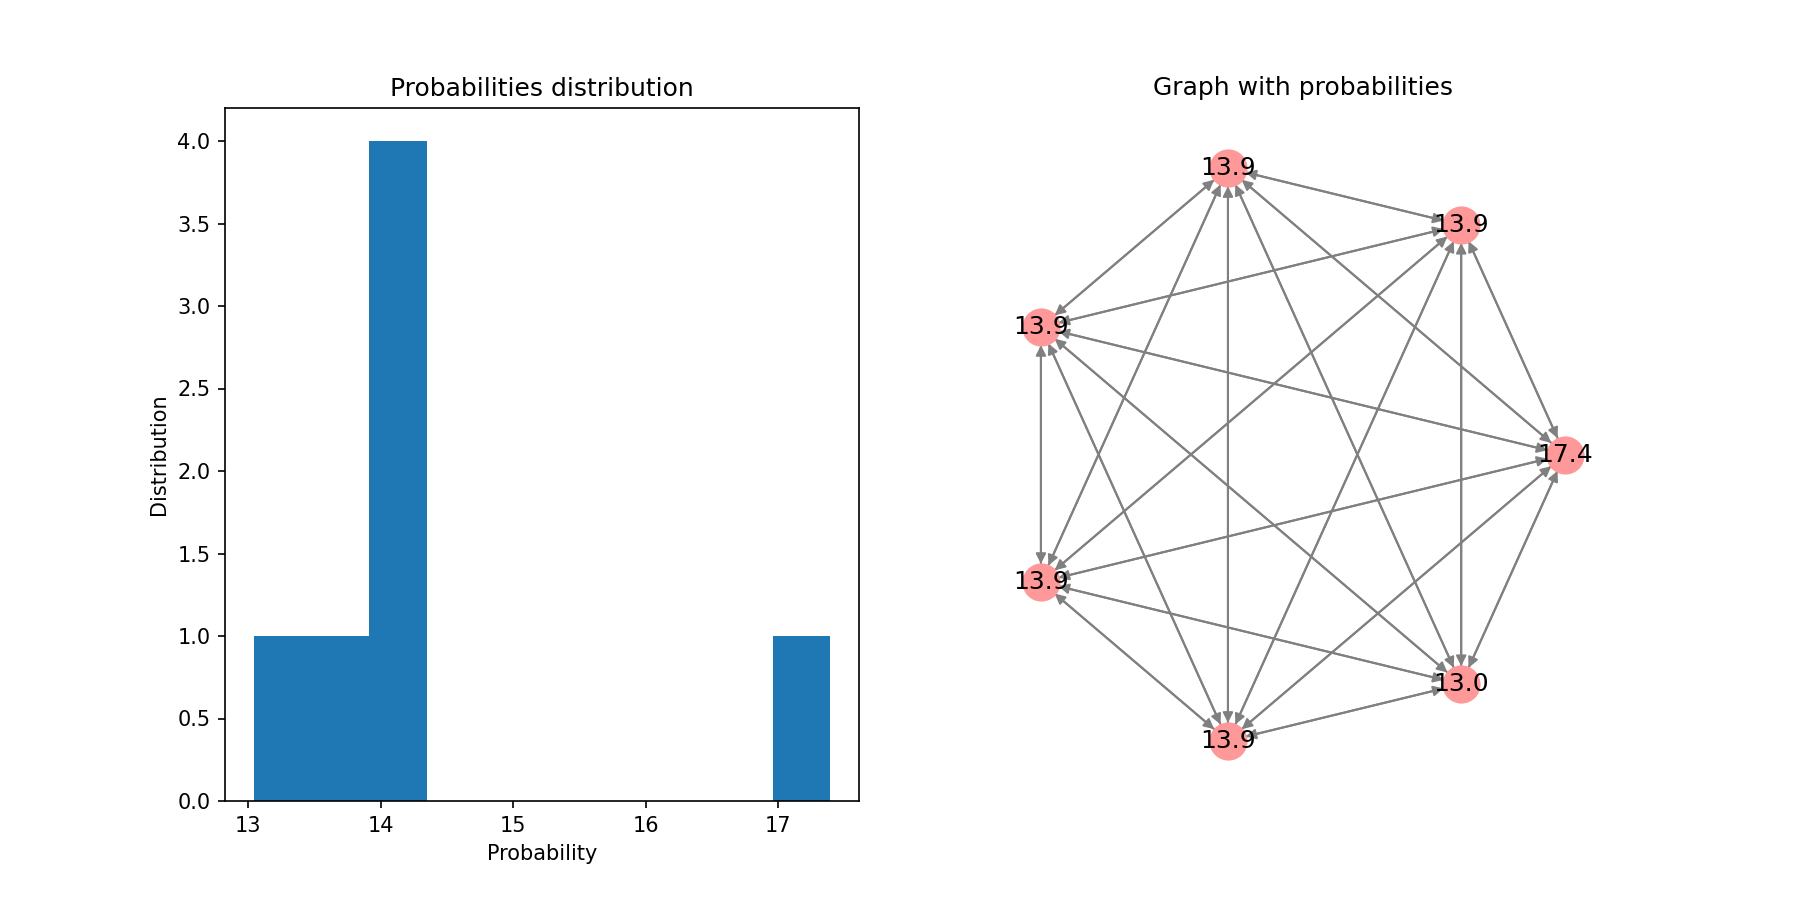

Probabilities: ['13.0', '13.9', '13.9', '13.9', '13.9', '13.9', '17.4']


In [135]:
n = 7
G = gnp_random_strongly_connected_graph(n, p=1)
e = np.array([0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0]).reshape(-1, 1)
probs = pagerank_with_jumps(G, e, d=0.9)
show_results(G, probs)

#### Test dla grafu pełnego, z niejednostajnym wektorem e, d = 0.95

(7, 7) (7, 1)


<IPython.core.display.Javascript object>


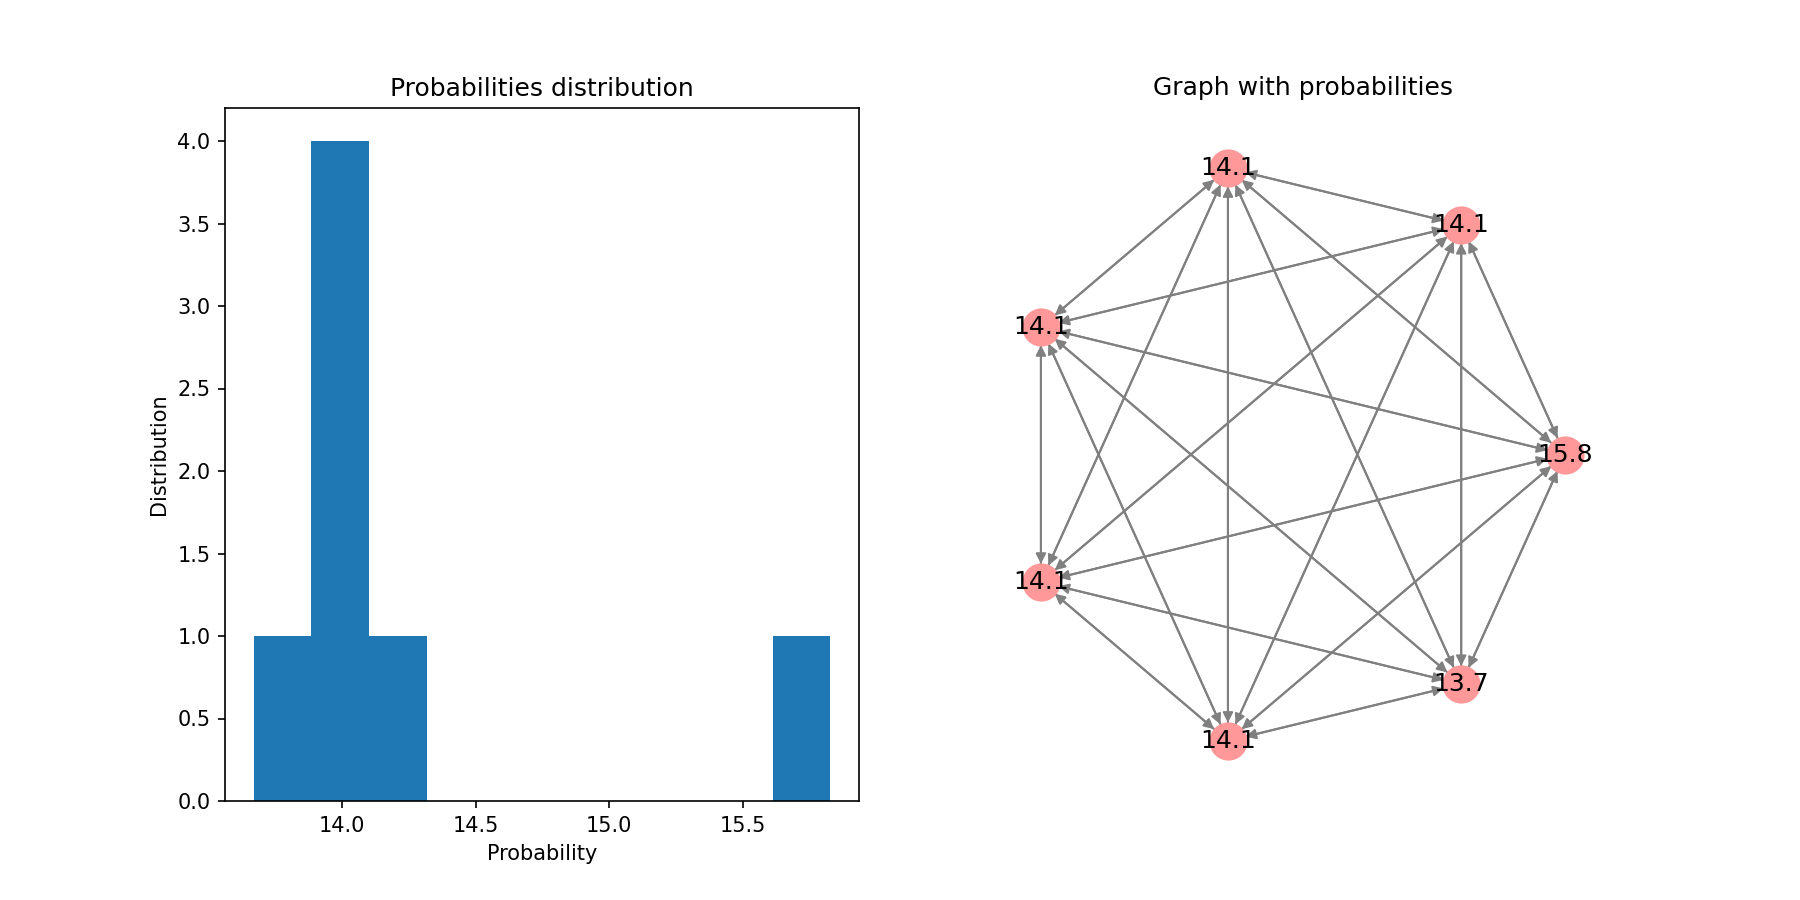

Probabilities: ['13.7', '14.1', '14.1', '14.1', '14.1', '14.1', '15.8']


In [136]:
n = 7
G = gnp_random_strongly_connected_graph(n, p=1)
e = np.array([0.5, 0.1, 0.1, 0.1, 0.1, 0.1, 0]).reshape(-1, 1)
probs = pagerank_with_jumps(G, e, d=0.95)
show_results(G, probs)

### Wnioski

Metoda wydaje się działać poprawnie.


Dla grafów pełnych niejednostajny rozkład **e** zaburza jednostajny rozkład prawdopodobieństwa (im bardziej d zbliża się do zera).

Dla grafu rzadkiego jednostajny rozkład **e** zaczyna wyrównywać prawdopodobieństwa. Wynika to z tego, że coraz wieksza role pelni w slepym chodzeniu po grafie pełni losowe, jednostajne wchodzenie do wierzchołków.  

## Grafy ze SNAPa

In [84]:
import requests
import io
import gzip
from contextlib import closing

def download_graph_str(link):
    res = requests.get(link)
    compressed_file = io.BytesIO()
    compressed_file.write(res.content)
    compressed_file.seek(0)
    decompressed_file = gzip.GzipFile(fileobj=compressed_file, mode='rb')
    return decompressed_file.read().decode()
    
def parse_graph_str(graph_str):
    G = nx.DiGraph()
    for line in graph_str.split('\n'):
        if line.startswith('#'):
            continue
        try:
            a, b = line.split()
        except ValueError:
            continue
        G.add_edge(int(a), int(b))
    return G

### email-Eu-core

In [137]:
email_eu_graph = "https://snap.stanford.edu/data/email-Eu-core.txt.gz"
graph_str = download_graph_str(email_eu_graph)

In [138]:
G = parse_graph_str(graph_str)

<IPython.core.display.Javascript object>


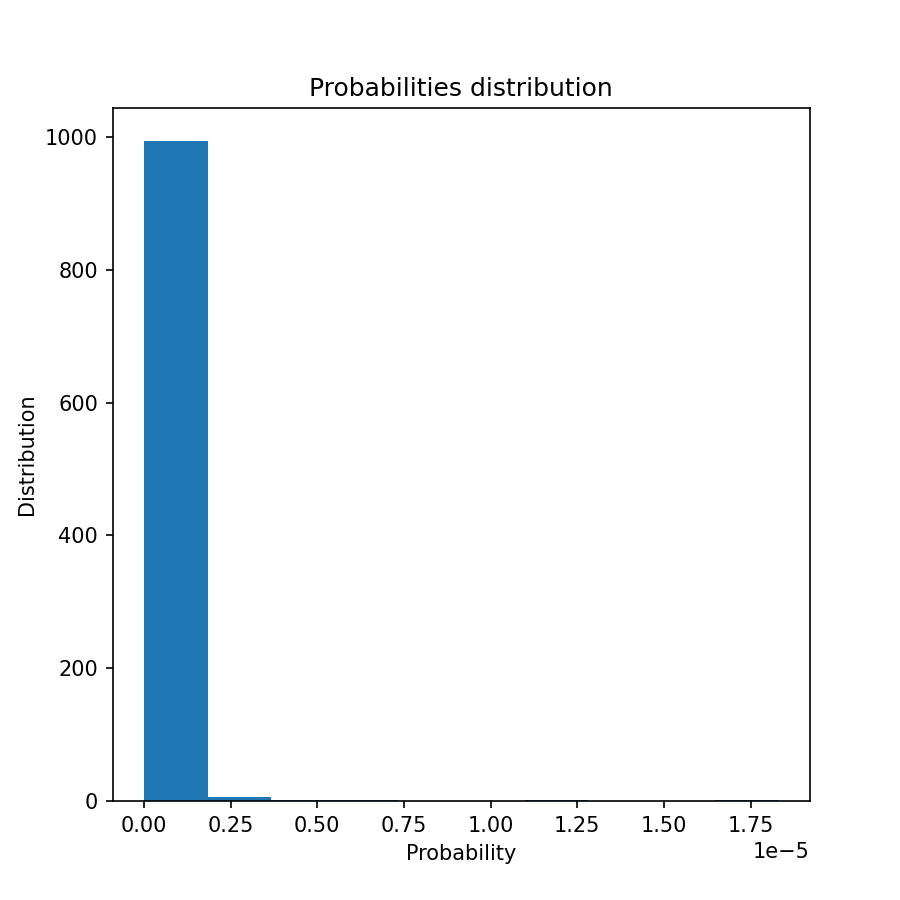

Wartość maksymalna 1.83e-5
Wartość minimalne 9.81e-9


In [147]:
n = G.number_of_nodes()
e = np.ones((n, 1)) / n
d = 0.95
probs = pagerank_with_jumps(G, e, d=d)
show_results(G, probs, show_graph=False, use_perc=False, print_probs=False)
print(f'Wartość maksymalna {nstr(mpf(np.max(probs)), 3)}')
print(f'Wartość minimalne {nstr(mpf(np.min(probs)), 3)}')

### Porównanie wyników

In [145]:
from itertools import product

berkstan_graph_link = "https://snap.stanford.edu/data/web-BerkStan.txt.gz"
email_eu_graph = "https://snap.stanford.edu/data/email-Eu-core.txt.gz"

G_mail = parse_graph_str(download_graph_str(email_eu_graph))
G_berk = parse_graph_str(download_graph_str(email_eu_graph))

pageranks = {}

ds = [0.5, 0.9, 0.95]

In [162]:
def fancy_str(x):
    return nstr(mpf(x), 3)


ranks = {}
for i, d in enumerate(ds):
    n = G.number_of_nodes()
    e = (np.ones((n, 1)) / n).reshape(-1, 1)
    ranks[(i, d)] = pagerank_with_jumps(G_mail, e, d)
pageranks['G_mail'] = ranks

for i, d in enumerate(ds):
    n = G.number_of_nodes()
    e = (np.ones((n, 1)) / n).reshape(-1, 1)
    ranks[(i, d)] = pagerank_with_jumps(G_berk, e, d)
pageranks['G_berk'] = ranks

pd_data = []
for name, data in pageranks.items():
#     print(name, data)
    for (_, d), v in data.items():
        row = [name]
        row.append(d)
        v = np.sort(v)
        last3 = [fancy_str(x) for x in v[[-1,-2,-3]].flatten()]
        row.append(last3)
        top3 = [fancy_str(x) for x in v[[0, 1, 2]].flatten()]
        row.append(top3)
        row.append(fancy_str(np.median(v)))
        row.append(fancy_str(np.mean(v)))
        pd_data.append(row)

pd.DataFrame(pd_data, columns=["graph type", "d", "last 3", "top 3", "median", "mean"])

,graph type,d,last 3,top 3,median,mean
0,G_mail,0.50,"[5.92e-8, 5.91e-8, 5.88e-8]","[1.41e-7, 3.48e-7, 2.0e-7]",1.01e-7,1.15e-7
1,G_mail,0.90,"[2.11e-8, 1.98e-8, 1.97e-8]","[2.39e-7, 5.09e-6, 4.12e-7]",1.4e-7,2.0e-7
2,G_mail,0.95,"[1.59e-8, 1.42e-8, 1.42e-8]","[2.74e-7, 1.85e-5, 4.82e-7]",1.57e-7,2.85e-7
3,G_berk,0.50,"[5.92e-8, 5.91e-8, 5.88e-8]","[1.41e-7, 3.48e-7, 2.0e-7]",1.01e-7,1.15e-7
4,G_berk,0.90,"[2.11e-8, 1.98e-8, 1.97e-8]","[2.39e-7, 5.09e-6, 4.12e-7]",1.4e-7,2.0e-7
5,G_berk,0.95,"[1.59e-8, 1.42e-8, 1.42e-8]","[2.74e-7, 1.85e-5, 4.82e-7]",1.57e-7,2.85e-7
